In [1]:
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

In [450]:
from skimage import data, color, exposure, img_as_ubyte, img_as_uint
from satsense.util import load_from_file, normalize_image, get_rgb_bands

# Supported image formats include RGB, Quickbird and Worldview
from satsense.util import RGB, QUICKBIRD, WORLDVIEW2

# URI to the image
#imagefile = '/home/bweel/Documents/projects/dynaslum/data/satelite/056239125010_01/056239125010_01_P001_MUL/08NOV02054348-M2AS_R1C1-056239125010_01_P001.TIF'
imagefile = '/home/bweel/Pictures/level-line-field.png'
# Set the correct format here, it is used throughout the notebook
bands = RGB

# Loading the file
dataset, image = load_from_file(imagefile)
image = normalize_image(image, bands)

In [453]:
from skimage.feature import canny

rgb_image = get_rgb_bands(image, bands)
img = color.rgb2gray(rgb_image)

In [454]:
edges = canny(img, sigma=1.5)

print(img.shape)
print(edges.shape)

(20, 20)
(20, 20)


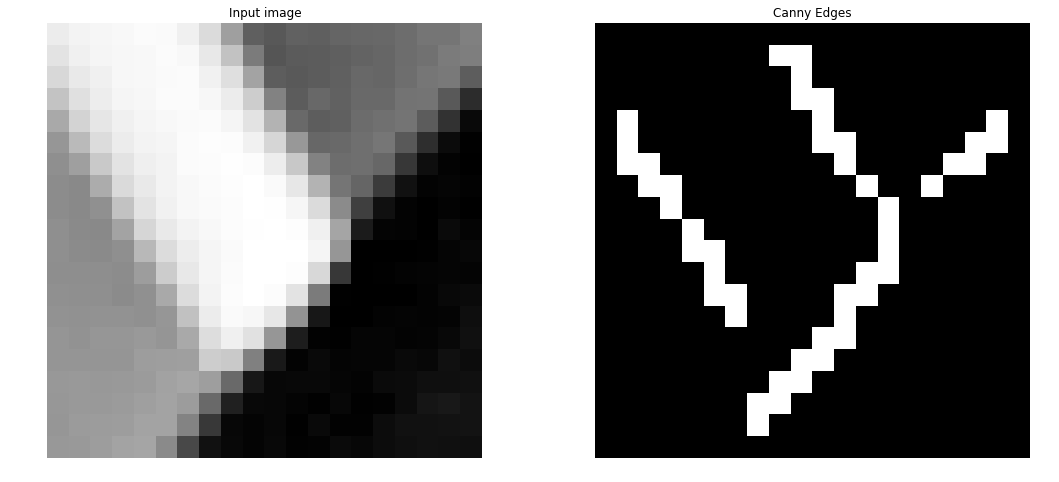

In [455]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8), sharex=True, sharey=True)

ax1.axis('off')
ax1.imshow(img, cmap=plt.cm.gray)
ax1.set_title('Input image')
ax1.set_adjustable('box-forced')

ax2.axis('off')
ax2.imshow(edges, cmap = plt.cm.gray)
ax2.set_title('Canny Edges')
ax1.set_adjustable('box-forced')
plt.show()

In [458]:
from skimage.transform import (hough_line, hough_line_peaks,
                               probabilistic_hough_line)

lines = probabilistic_hough_line(edges, line_length=2,
                                 line_gap=1)

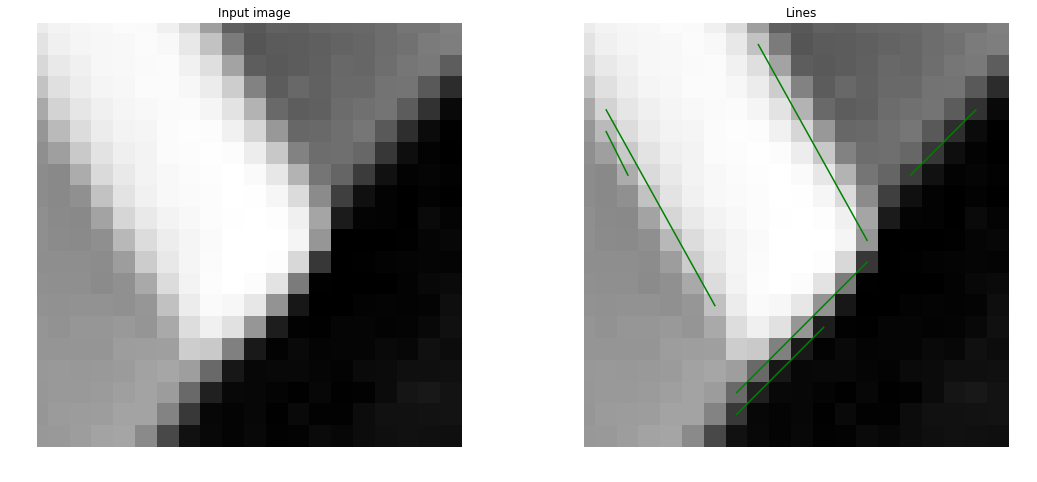

In [459]:
# fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(18, 8), sharex=True, sharey=True)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8), sharex=True, sharey=True)

ax1.axis('off')
ax1.imshow(img, cmap=plt.cm.gray)
ax1.set_title('Input image')
ax1.set_adjustable('box-forced')


ax2.axis('off')
ax2.imshow(img, cmap=plt.cm.gray)
ax2.set_xlim((0, edges.shape[1]))
ax2.set_ylim((edges.shape[0], 0))

# ax3.axis('off')
# ax3.imshow(edges, cmap=plt.cm.gray)
# ax3.set_xlim((0, edges.shape[1]))
# ax3.set_ylim((edges.shape[0], 0))

for line in lines:
    p0, p1 = line
    ax2.plot((p0[0], p1[0]), (p0[1], p1[1]),'g')
#     ax3.plot((p0[0], p1[0]), (p0[1], p1[1]),'g')

ax2.set_title('Lines')
ax2.set_adjustable('box-forced')

# ax3.set_title('Lines')
# ax3.set_adjustable('box-forced')

# ax4.set_adjustable('box-forced')
# ax4.axis('off')

plt.show()

In [460]:
import cv2
from satsense.util import get_rgb_bands

window = get_grayscale_image(img, bands)

In [624]:
gx = cv2.Sobel(window, cv2.CV_64F, 1, 0, ksize=3)
gy = cv2.Sobel(window, cv2.CV_64F, 0, 1, ksize=3)

mag, angle = cv2.cartToPolar(gx, gy, angleInDegrees=True)

mag2 = np.ones(angle.shape)

gx2, gy2 = cv2.polarToCart(mag2, -angle, angleInDegrees=True)

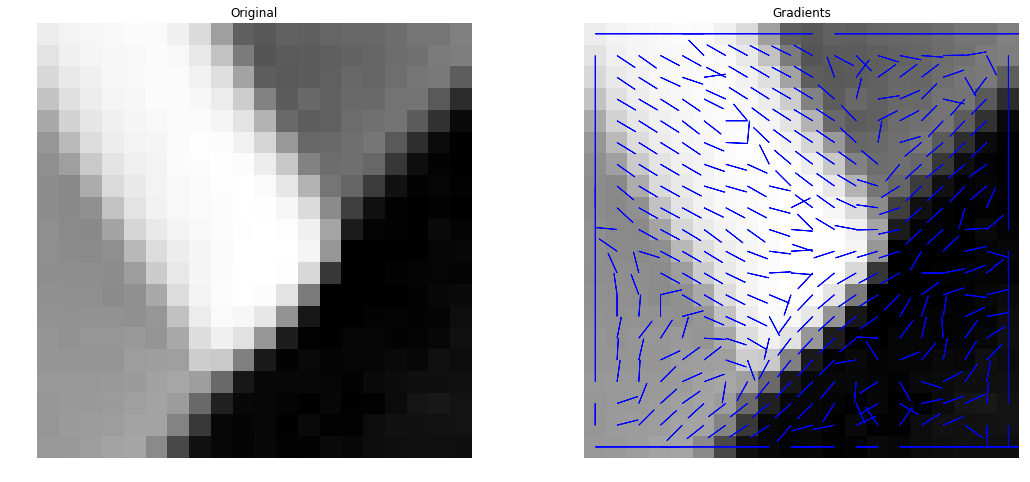

In [625]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8), sharex=True, sharey=True)

ax1.axis('off')
ax1.imshow(window, cmap=plt.cm.gray)
ax1.set_title('Original')
ax1.set_adjustable('box-forced')

ax2.axis('off')
ax2.imshow(window, cmap=plt.cm.gray)
ax2.set_title('Gradients')
ax2.set_adjustable('box-forced')
for i in range(angle.shape[0]):
    for j in range(angle.shape[1]):
        ax2.arrow(j, i, gx2[i, j], gy2[i, j], head_width=0, head_length=0, fc='b', ec='b')

plt.show()

In [646]:
# print(np.unravel_index(mag.argsort(axis=None), mag.shape))

def neighbors(pixel):
    x, y = pixel
    X, Y = mag.shape
    candidates = np.array([(x-1, y-1), (x-1, y), (x-1, y+1), (x, y-1), (x, y+1), (x+1, y-1), (x+1, y), (x+1, y+1)])
    return candidates


# def neighbourhood(mag, pixel):
#     x, y = pixel
#     X, Y = mag.shape
#     neighbourhood = []
#     if x - 1 > 0:
#         neighbourhood.append((x-1, y))
#         if y - 1 > 0:
#             neighbourhood.append((x-1, y-1))
#         if y + 1 < Y:
#             neighbourhood.append((x-1, y+1))
#     if x + 1 < X:
#         neighbourhood.append((x+1, y))
#         if y - 1 > 0:
#             neighbourhood.append((x+1, y-1))
#         if y + 1 < Y:
#             neighbourhood.append((x+1, y+1))
#     if y - 1 > 0:
#         neighbourhood.append((x, y-1))
#     if y + 1 < Y:
#         neighbourhood.append((x, y+1))
    
#     return neighbourhood
        

def grow_region(mag, angle, seed, tolerance, used):
    region = []
    region.append(seed)
    used[seed] = 1.0
    region_angle = angle[seed]
    
    Sx = np.cos(region_angle)
    Sy = np.sin(region_angle)
    added = 1
    while added > 0:
        added = 0
        for P in region:
            for Q in neighbors(P):
                x1, y1 = Q
                if x1 > 0 and x1 < mag.shape[0] and y1 > 0 and y1 < mag.shape[1] and not used[x1, y1]:
                    print("region_angle: ", region_angle, "angle:", angle[x1,y1])
                    diff = region_angle - angle[x1, y1]
                    if diff < 0:
                        diff += 360.0

                    print("difference is: ", diff)
                    if  diff < tolerance:
                        print("adding:", x1, y1)
                        region.append([x1, y1])
                        used[x1, y1] = 1
                        Sx = Sx + np.cos(np.deg2rad(angle[x1, y1]))
                        Sy = Sy + np.sin(np.deg2rad(angle[x1, y1]))
                        region_angle = np.rad2deg(np.arctan(Sy/Sx))
                        if region_angle < 0:
                            region_angle += 360
                        added = 1
    
    
    return region, used

sorted_indices = mag.argsort(axis=None)
index = np.unravel_index(sorted_indices, mag.shape)

used = np.zeros(mag.shape)
regions = []
#for seed_idx in range(len(index[0])-1, 0, -1):
seed_idx = len(index[0])-1
seed = index[0][seed_idx], index[1][seed_idx]
#if not used[seed[0], seed[1]]:
region, used = grow_region(mag, angle, seed, 22.5, used)
regions.append(region)
# print(region)

seed is: (12, 12)
region_angle:  214.240610607 angle: 219.289047035
difference is:  354.951563572
region_angle:  214.240610607 angle: 209.920927213
difference is:  4.319683394
adding: 11 12
region_angle:  302.501857639 angle: 207.696225993
difference is:  94.8056316464
region_angle:  302.501857639 angle: 220.263223802
difference is:  82.2386338365
region_angle:  302.501857639 angle: 211.920710012
difference is:  90.5811476269
region_angle:  302.501857639 angle: 221.941776743
difference is:  80.5600808956
region_angle:  302.501857639 angle: 218.657489661
difference is:  83.8443679782
region_angle:  302.501857639 angle: 214.587028704
difference is:  87.9148289345
region_angle:  302.501857639 angle: 197.907950928
difference is:  104.593906711
region_angle:  302.501857639 angle: 197.787337959
difference is:  104.71451968
region_angle:  302.501857639 angle: 196.488218949
difference is:  106.01363869
region_angle:  302.501857639 angle: 219.289047035
difference is:  83.2128106044
region_angle

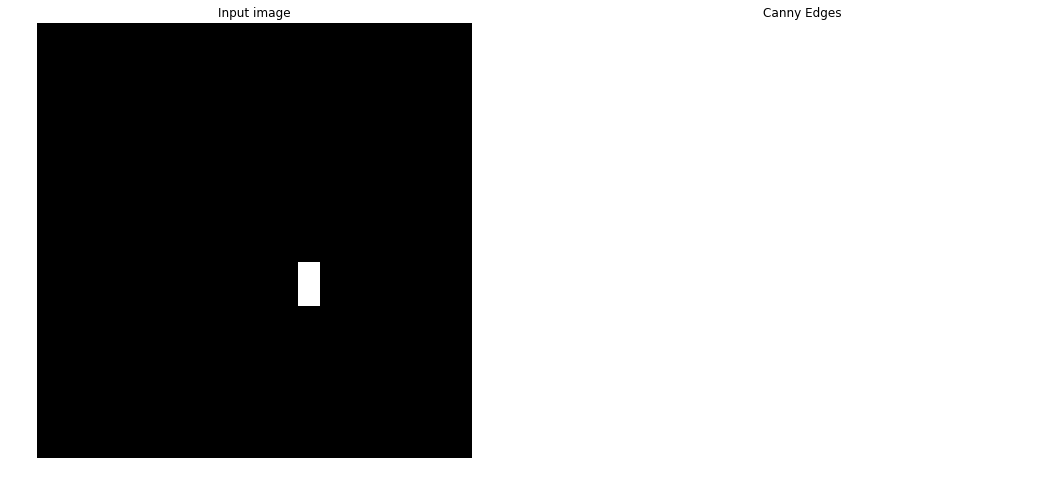

In [643]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8), sharex=True, sharey=True)

ax1.axis('off')
ax1.imshow(used, cmap=plt.cm.gray)
ax1.set_title('Input image')
ax1.set_adjustable('box-forced')

ax2.axis('off')
# ax2.imshow(edges, cmap = plt.cm.gray)
ax2.set_title('Canny Edges')
ax1.set_adjustable('box-forced')
plt.show()